# Data Description
- This data set provides the following statistics for each of the 50 U.S. states in 1973:
    - Crime Rates (per 100,000 residents):
        - `Assault`: Assault arrests per 100,000 residents
        - `Murder`: Murder arrests per 100,000 residents
        - `Rape`: Rape arrests per 100,000 residents
    - Demographic Information:
        - `UrbanPop`: Percentage of the population living in urban areas
- There are 50 rows which are 50 states in US.

# Load Packages and Data

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage

- `USArrests` is a data set in R computing environment.
- We use `get_rdataset()` to retrieve data.
- `get_rdataset()` can fetch data from many R packages.

In [3]:
USArrests = get_rdataset('USArrests').data
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [4]:
USArrests.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


# Principal Components Analysis

- Issue with Variable Scales: The variables have vastly different standard deviation. The UrbanPop variable shows the percentage of urban population, while the rape rate is on a different scale. These scale differences can distort PCA results.
- Impact on PCA: PCA identifies derived variables (principal components) that capture most of variance in the data. If the variables are not scaled, PCA will be dominated by the variable with the largest variance, which is `Assault`. This would overshadow the contribution of other variables.
- Solution: To ensure PCA is not biased by different scales, we standardize the variables to have mean 0 and standard deviation 1 before applying PCA.

In [5]:
scaler = StandardScaler(with_std=True, with_mean=True)
USArrests_scaled = scaler.fit_transform(USArrests)

In [6]:
pcaUS = PCA()
pcaUS.fit(USArrests_scaled);

- By default, the `PCA()` transform centers the variables (i.e., sets their mean to zero) but does not scale them (i.e., does not adjust their standard deviations).  
- After calling the `fit()` method, the `pcaUS` object contains several useful quantities:
    - The `mean_` attribute contains the mean of each variable.	Because we standardized the variables, these are all close to zero.
    - The `components_` attribute contains the principal component loadings.
    - We use `transform()` method of the `pcaUS` object to compute the principal component scores of the states.

In [7]:
pcaUS.mean_.round(3)

array([-0.,  0., -0.,  0.])

In [8]:
# components_
pd.DataFrame(pcaUS.components_.round(3), columns=USArrests.columns, index=['PC1', 'PC2', 'PC3', 'PC4'])

,Murder,Assault,UrbanPop,Rape
PC1,0.536,0.583,0.278,0.543
PC2,-0.418,-0.188,0.873,0.167
PC3,-0.341,-0.268,-0.378,0.818
PC4,-0.649,0.743,-0.134,-0.089


In [9]:
# Original data
pd.DataFrame(USArrests_scaled[:3].round(3), columns=USArrests.columns)

,Murder,Assault,UrbanPop,Rape
0,1.255,0.791,-0.526,-0.003
1,0.513,1.118,-1.224,2.509
2,0.072,1.494,1.009,1.053


In [10]:
scores = pcaUS.transform(USArrests_scaled)
scores[:3].round(3)

array([[ 0.986, -1.133, -0.444, -0.156],
       [ 1.95 , -1.073,  2.04 ,  0.439],
       [ 1.763,  0.746,  0.055,  0.835]])

- The scores has following properties:
    - Row (50): Each row corresponds to an observation (a state).
    - Column (4): Each column corresponds to a principal component.
        - The first column is the first principal component which explains the most variance. The second column is the second principal component, and so on.
    - Each element in the scores matrix represents the projection of an observation onto a principal component.
    - 0.986 = 1.255 * 0.536 + 0.791 * 0.583 - 0.278 * 0.526 - 0.543 * 0.003
    - The first observation has a positive and relatively strong contribution to the first principal component.
- The `biplot` is a common PCA visualization method, but it's not built into `sklearn`.
- We create a simple `biplot` manually.

- Principal components and sign ambiguity: PCs are not unique in sign; the direction (or "sign") of a component can be reversed, and this does not affect the data’s underlying structure or meaning.
- By flipping the signs of the second set of scores and loadings, we create a graph that mirrors the first one.

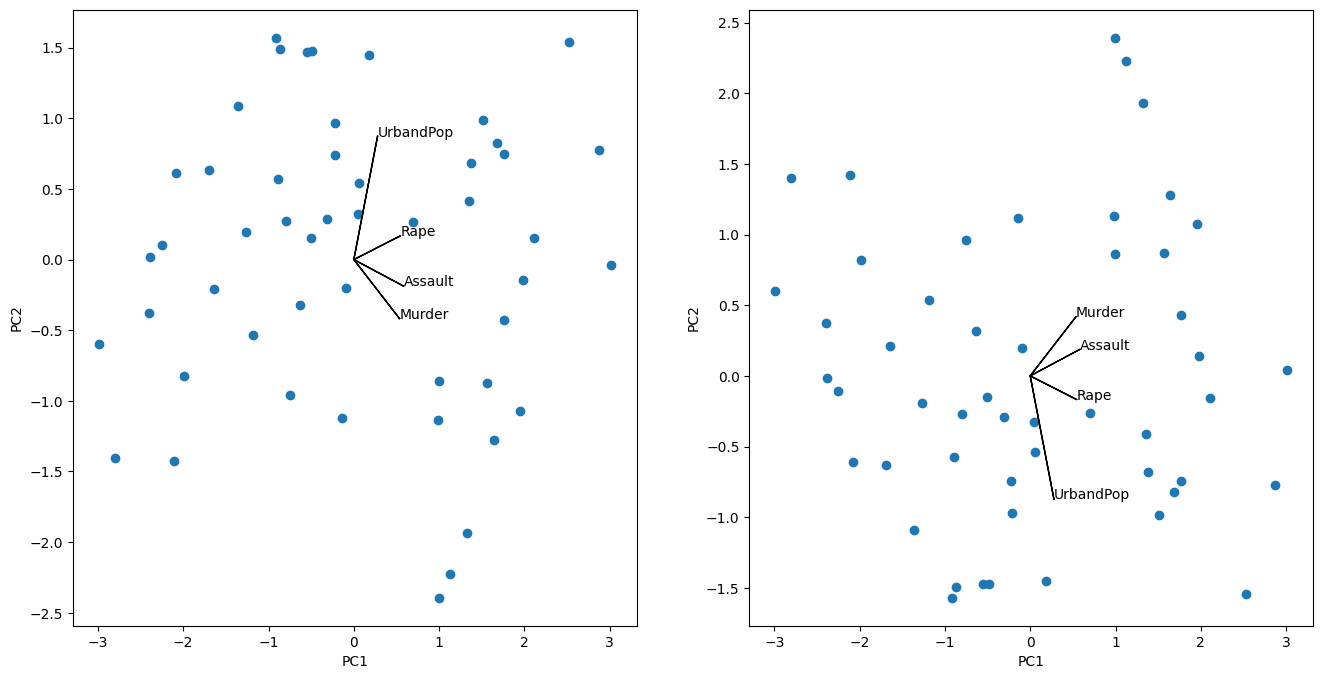

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# Left plot
# Scatter plot of the scores of the first two principal components
axes[0].scatter(scores[:, 0], scores[:, 1])
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
# First Variable
axes[0].arrow(0, 0, pcaUS.components_[0, 0], pcaUS.components_[1, 0])
axes[0].text(pcaUS.components_[0, 0], pcaUS.components_[1, 0], 'Murder')
# Second Variable
axes[0].arrow(0, 0, pcaUS.components_[0, 1], pcaUS.components_[1, 1])
axes[0].text(pcaUS.components_[0, 1], pcaUS.components_[1, 1], 'Assault')
# Third Variable
axes[0].arrow(0, 0, pcaUS.components_[0, 2], pcaUS.components_[1, 2])
axes[0].text(pcaUS.components_[0, 2], pcaUS.components_[1, 2], 'UrbandPop')
# Forth Variable
axes[0].arrow(0, 0, pcaUS.components_[0, 3], pcaUS.components_[1, 3])
axes[0].text(pcaUS.components_[0, 3], pcaUS.components_[1, 3], 'Rape')

# Right plot
axes[1].scatter(scores[:, 0], -scores[:, 1])
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
# First Variable
axes[1].arrow(0, 0, pcaUS.components_[0, 0], -pcaUS.components_[1, 0])
axes[1].text(pcaUS.components_[0, 0], -pcaUS.components_[1, 0], 'Murder')
# Second Variable
axes[1].arrow(0, 0, pcaUS.components_[0, 1], -pcaUS.components_[1, 1])
axes[1].text(pcaUS.components_[0, 1], -pcaUS.components_[1, 1], 'Assault')
# Third Variable
axes[1].arrow(0, 0, pcaUS.components_[0, 2], -pcaUS.components_[1, 2])
axes[1].text(pcaUS.components_[0, 2], -pcaUS.components_[1, 2], 'UrbandPop')
# Forth Variable
axes[1].arrow(0, 0, pcaUS.components_[0, 3], -pcaUS.components_[1, 3])
axes[1].text(pcaUS.components_[0, 3], -pcaUS.components_[1, 3], 'Rape');

In [12]:
# Standard deviations of the principal component scores
scores.std(0, ddof=1)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

In [13]:
# Variance of the principal component scores
scores.std(0, ddof=1)**2

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [14]:
# Variance of the principal component scores
pcaUS.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [15]:
# Proportion of variance explained by each principal component (PVE)
pcaUS.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

- The first principal component explains 62.0% of the variance in the data.
- The second principal component explains 24.7% of the variance, and so on.
- We visualize the Proportion of Variance Explained (PVE) by each component, as well as the cumulative PVE.

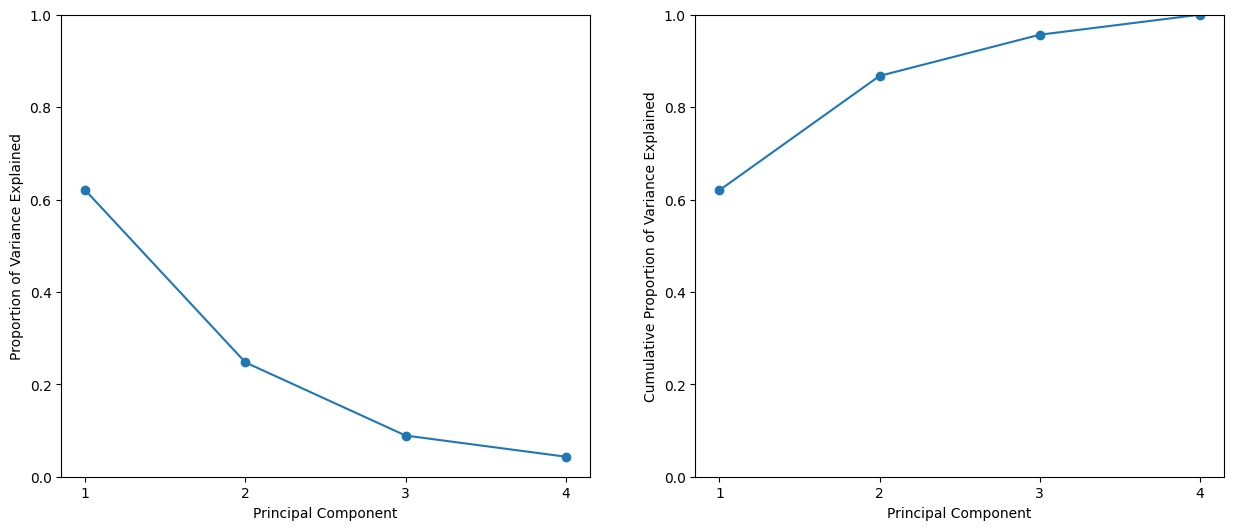

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# PVE on the left plot
axes[0].plot([1,2,3,4], pcaUS.explained_variance_ratio_, marker='o')
axes[0].set_xlabel('Principal Component'); axes[0].set_ylabel('Proportion of Variance Explained')
axes[0].set_ylim([0,1]); axes[0].set_xticks([1,2,3,4])
# Cumulative PVE on the right plot
axes[1].plot([1,2,3,4], np.cumsum(pcaUS.explained_variance_ratio_), marker='o')
axes[1].set_xlabel('Principal Component'); axes[1].set_ylabel('Cumulative Proportion of Variance Explained')
axes[1].set_ylim([0,1]); axes[1].set_xticks([1,2,3,4]);

# Matrix Completion
- Solving the optimization problem of PCA on a centered data matrix $X$ is equivalent to computing the first $M$ PCs of the data.
- We used our scaled and centered $X$.
- The singular value decomposition (SVD) is general algorithm for solving the PCA optimization problem.
    - The SVD decomposes $X$ into three matrices: $X = U \cdot D \cdot V^T$.
    - $U$: This is an orthogonal matrix where the columns are the left singular vectors of $X$. Each column represents a principal component in the original data space.
    - $D$: This is a diagonal matrix (return as 1D array) containing the singular values of $X$. The singular values are related to the amount of variance captured by each principal component. Larger values indicate that the corresponding principal component captures more variance.
    - $V$: This is an orthogonal matrix where the rows are the right singular vectors of $X$. Each row represents a principal component in feature space.

In [17]:
X = USArrests_scaled
U, D, V = np.linalg.svd(X, full_matrices=False)
U.shape, D.shape, V.shape

((50, 4), (4,), (4, 4))

- `full_matrices=False`ensures ``U`` has the same shape of ``X``.

In [18]:
V

array([[-0.53589947, -0.58318363, -0.27819087, -0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [ 0.34123273,  0.26814843,  0.37801579, -0.81777791],
       [ 0.6492278 , -0.74340748,  0.13387773,  0.08902432]])

In [19]:
pcaUS.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

- $U$: Standardized PCA score matrix (columns have sum-of-squares equal to one).
- $D$: Vectors of singular values.
- $PCA Scores$: Obtained by multiplying each column of $U$ by the corresponding element of $D$. $$\text{PCA Scores} = U \cdot D$$

In [20]:
(U * D[None,:])[:3]

array([[-0.98556588, -1.13339238,  0.44426879,  0.15626714],
       [-1.95013775, -1.07321326, -2.04000333, -0.43858344],
       [-1.76316354,  0.74595678, -0.05478082, -0.83465292]])

In [21]:
scores[:3]

array([[ 0.98556588, -1.13339238, -0.44426879, -0.15626714],
       [ 1.95013775, -1.07321326,  2.04000333,  0.43858344],
       [ 1.76316354,  0.74595678,  0.05478082,  0.83465292]])

- We omit 20 entries in 50 x 4 data matrix at random:
    - Select 20 rows (states) at random.
    - For each selected row, randomly choose one of the four entries to omit.
    - This method ensures that every row retains at least three observed values.

In [22]:
n_omit = 20
np.random.seed(15)
r_idx = np.random.choice(np.arange(50), 20, replace=False)
c_idx = np.random.choice(np.arange(4), n_omit, replace=True)
Xna = X.copy()
Xna[r_idx, c_idx] = np.nan
Xna

array([[ 1.25517927,  0.79078716, -0.52619514, -0.00345116],
       [ 0.51301858,  1.11805959, -1.22406668,  2.50942392],
       [ 0.07236067,  1.49381682,  1.00912225,  1.05346626],
       [ 0.23470832,  0.23321191, -1.08449238,         nan],
       [ 0.28109336,  1.2756352 ,  1.77678094,  2.08881393],
       [ 0.02597562,  0.40290872,  0.86954794,  1.88390137],
       [-1.04088037, -0.73648418,  0.79976079, -1.09272319],
       [-0.43787481,  0.81502956,  0.45082502, -0.58583422],
       [ 1.76541475,  1.99078607,  1.00912225,  1.1505301 ],
       [        nan,  0.48775713, -0.38662083,  0.49265293],
       [-0.57702994, -1.51224105,  1.21848371, -0.11129987],
       [-1.20322802, -0.61527217, -0.80534376, -0.75839217],
       [ 0.60578867,  0.94836277,  1.21848371,  0.29852525],
       [-0.13637203, -0.70012057, -0.03768506, -0.0250209 ],
       [-1.29599811, -1.39102904, -0.5959823 ,         nan],
       [-0.41468229, -0.67587817,  0.03210209, -0.34856705],
       [ 0.44344101,    

![Algorithm 12.1](https://i.imgur.com/PFICDhP.png)

- Step 1:
    - Make a copy of the original data to avoid overwriting ``Xna`` when assigning values to `Xhat`.
    - Compute the column means of the non-missing entries using ``np.nanmean()`` and store them in ``Xbar``.
    - Initialize `Xhat` ($\tilde{X}$) by replacing the missing values with the corresponding column means from ``Xbar``.   

In [23]:
Xhat = Xna.copy()
Xbar = np.nanmean(Xhat, axis=0)
Xhat[r_idx, c_idx] = Xbar[c_idx]

- Logical Matrix ``ismiss``:
    - ``ismiss`` is a logical matrix with the same dimensions as ``Xna``.
    - An element is `True` if the corresponding element in ``Xna`` is missing, and `False` otherwise.
    - The notation ``~ismiss`` negates this boolean matrix.
- Mean of Squared Non-Missing Elements:
    - We store the mean of the squared non-missing elements in ``mss0``.
- Mean Squared Error (MSE):
    - We store MSE of the non-missing elements of the old version of ``Xhat`` in ``mssold``. Initially, ``mssold`` agrees with ``mss0``.
    - We plan to store MSE of the non-missing elements of the current version of ``Xhat`` in ``mss``.
- Iteration Criteria:
    - We iterate Step 2 of Algorithm 12.1 until the relative error, defined as ``(mssold - mss) / mss0``, falls below ``thresh = 1e-7``.
    - Algorithm 12.1 instructs us to iterate Step 2 until the relative error is no longer decreasing.
    - Tracking ``(mssold - mss) / mss0`` ensures that the number of iterations required for convergence does not depend on whether the raw data ``X`` was multiplied by a constant factor.

In [24]:
# Logical matrix ismiss
ismiss = np.isnan(Xna)
# MSE of all non-missing values
mss0 = np.mean(Xna[~ismiss]**2) 
# MSE of old version
mssold = np.mean(Xhat[~ismiss]**2)
# mssold = mss0
print('Difference between mss0 and mssold:', mss0 - mssold)
# Iteration Criteria
thresh = 1e-7
rel_err = 1
count = 0

Difference between mss0 and mssold: 0.0


- We write a function take takes in a matrix and return an approximation of the matrix using  ``svd()``. This will be needed in Step 2. 

In [25]:
def low_rank(X, M=1):
    U, D, V = np.linalg.svd(X)
    L = U[:,:M] * D[None,:M]
    return L.dot(V[:M])

- Step 2:
    - (a): Approximate `Xhat` using `low_rank()` and store the result in `Xapp`.
    - (b): Use `Xapp` to update the estimates for the missing elements in `Xhat` (those missing in Xna).
    - (c): Compute the relative error.
- Details on step 2a:
    - Perform SVD to decompose $X$ into U $(50 \times 50)$, D (length 4), and V $(4 \times 4)$.
    - Select the first M columns of U and the first M singular values from D.
    - Multiply these to form L $(50 \times M)$.
    - Multiply L by the first M rows of V to get the low-rank approximation Xapp $(50 \times 4)$.
- Explanation on step 2a:
    - This approximates `Xhat` using a rank-1 approximation (since `M=1`).
    - The resulting `Xapp` is then used in subsequent steps to update the missing values in `Xhat`.
    - `low_rank()` approximates the matrix `X` by retaining only the first `M` singular values and their corresponding singular vectors. This provides a low-rank approximation that captures the most significant patterns in the data while reducing noise and complexity.
- Explanation on UDV:
    - The columns of $U$ are called the left singular vectors of $X$.
    - The left singular vectors are orthonormal. $U^T \cdot U = I$.
    - The left singular vectors represent directions in the row space of $X$. They form an orthonormal basis for this space. They are used to capture the most significant patterns in the data. The first left singular vector corresponds to the direction of maximum variance in the data, the second to the direction of the next highest variance orthogonal to the first, and so on.
    - Each left singular vector corresponds to a principal component in the row space of $X$. When $X$ is projected onto these vectors, the resulting coordinates (the singular values) indicate how much of the data's variance is captured by each principal component.
    - The singular values in $D$ indicate the amount of variance captured by each corresponding singular vector.

In [26]:
while rel_err > thresh:
    count += 1
    # Step 2(a)
    Xapp = low_rank(Xhat, M=1)
    # Step 2(b)
    Xhat[ismiss] = Xapp[ismiss]
    # Step 2(c)
    mss = np.mean(((Xna - Xapp)[~ismiss])**2)
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}"
          .format(count, mss, rel_err))

Iteration: 1, MSS:0.395, Rel.Err 5.99e-01
Iteration: 2, MSS:0.382, Rel.Err 1.33e-02
Iteration: 3, MSS:0.381, Rel.Err 1.44e-03
Iteration: 4, MSS:0.381, Rel.Err 1.79e-04
Iteration: 5, MSS:0.381, Rel.Err 2.58e-05
Iteration: 6, MSS:0.381, Rel.Err 4.22e-06
Iteration: 7, MSS:0.381, Rel.Err 7.65e-07
Iteration: 8, MSS:0.381, Rel.Err 1.48e-07
Iteration: 9, MSS:0.381, Rel.Err 2.95e-08


- We compute the correlation between the 20 imputed values and the actual values.

In [27]:
np.corrcoef(Xapp[ismiss], X[ismiss])[0,1]

0.7113567434297361